In [35]:
# Taken from https://github.com/aaxwaz/Fraud-detection-using-deep-learning/blob/master/auto-encoder/autoencoder_demo.ipynb

import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 

In [36]:
#df = pd.read_csv('/host/data/data_exploration_output_1000lines.csv')
df = pd.read_csv('data_exploration_filtered_lat.csv')

#cols = ["time","p(src_user)","p(dest_user)","p(src_nt_host)","p(dest_nt_host)","p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)"]
cols = ["p(src_user)","p(dest_user)","p(src_nt_host)","p(dest_nt_host)","p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)", "is_malicious"]

df = df[cols]

print("DF Shape: " + str(df.shape))

DF Shape: (296542, 11)


In [37]:
df.head(1)

,p(src_user),p(dest_user),p(src_nt_host),p(dest_nt_host),p(src_user n dest_user),p(src_nt_host n dest_nt_host),p(dest_user n dest_nt_host),p(src_nt_host|dest_nt_host),p(dest_user|src_user),p(dest_nt_host|dest_user),is_malicious
0,0.004138,0.004138,0.024452,0.607917,0.000017,0.014865,0.002516,0.024452,0.004138,0.607917,0


In [81]:
TEST_RATIO = 0.25
#df.sort_values('time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
#train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_x = df.iloc[:TRA_INDEX, 0:-1].values
#train_x = df.iloc[:TRA_INDEX, :].values
train_y = df.iloc[:TRA_INDEX, -1].values
#train_y = df.iloc[:TRA_INDEX, :].values

#test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_x = df.iloc[TRA_INDEX:, 0:-1].values
#test_x = df.iloc[TRA_INDEX:, :].values
test_y = df.iloc[TRA_INDEX:, -1].values
#test_y = df.iloc[TRA_INDEX:, :].values

In [82]:
print("Total train examples: {}, total malicious cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

print("Total test examples: {}, total malicious cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))


Total train examples: 222406, total malicious cases: 5, equal to 0.00002 of total cases. 
Total test examples: 74136, total malicious cases: 101, equal to 0.00136 of total cases. 


In [160]:
# ## Modelling and results
# 

# ## 1. Auto-encoder as unsupervised learning

# Parameters
learning_rate = 0.001
training_epochs = 20
#training_epochs = 500
batch_size = 256
#batch_size = 32
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

In [171]:
# ### Train and val the model - (1 hidden layer turned out to be enough)

X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

In [172]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   #biases['decoder_b2']))
    return layer_1



In [173]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

#print("========= Batch MSE Shape =========")
#print(batch_mse.shape)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

In [174]:
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            #print("========= Batch MSE Shape =========")
            #print(batch_mse.shape)
            #print(train_batch_mse.shape)
            #print(type(batch_mse))
            #print("====================TRAIN BATCH MSE=======================")
            #print(train_batch_mse)
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))
            #print("Epoch:"+ str((epoch+1)))
        #print("cost=" + str(c)) 
            #print("Train auc="+ str(auc(train_y, train_batch_mse))) 
            #print("Time elapsed="+ str(datetime.now() - now)))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)

Epoch: 0001 cost= 0.000554033 Train auc= 0.999996 Time elapsed= 0:00:02.332990
Epoch: 0002 cost= 0.000101615 Train auc= 0.999996 Time elapsed= 0:00:02.932059
Epoch: 0003 cost= 0.000082424 Train auc= 0.999822 Time elapsed= 0:00:03.577395
Epoch: 0004 cost= 0.000046042 Train auc= 0.999816 Time elapsed= 0:00:04.228541
Epoch: 0005 cost= 0.000051611 Train auc= 0.999816 Time elapsed= 0:00:04.827631
Epoch: 0006 cost= 0.000036241 Train auc= 0.999816 Time elapsed= 0:00:05.480811
Epoch: 0007 cost= 0.000044642 Train auc= 0.999816 Time elapsed= 0:00:06.045917
Epoch: 0008 cost= 0.000061244 Train auc= 0.999816 Time elapsed= 0:00:06.612897
Epoch: 0009 cost= 0.000027860 Train auc= 0.999816 Time elapsed= 0:00:07.163090
Epoch: 0010 cost= 0.000059302 Train auc= 0.999816 Time elapsed= 0:00:07.699002
Epoch: 0011 cost= 0.000059954 Train auc= 0.999804 Time elapsed= 0:00:08.242339
Epoch: 0012 cost= 0.000036473 Train auc= 0.999662 Time elapsed= 0:00:08.784968
Epoch: 0013 cost= 0.000025311 Train auc= 0.999880 Ti

In [175]:
# ### Test model - on later 25% test data

save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt


In [130]:
THRE_TEST = 0

In [104]:
print("Let's, for example, use 2 as our detection threshold: \nNumber of detected cases above treshold: {}, \nNumber of pos cases only above threshold: {}, \nThe percentage of accuracy above treshold (Precision): {:0.2f}%. \nCompared to the average percentage of malicious traffic in test set: 0.132%".format( np.sum(test_batch_mse > THRE_TEST), np.sum(test_y[test_batch_mse > THRE_TEST]), np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST) * 100))

Let's, for example, use 2 as our detection threshold: 
Number of detected cases above treshold: 33, 
Number of pos cases only above threshold: 33, 
The percentage of accuracy above treshold (Precision): 100.00%. 
Compared to the average percentage of malicious traffic in test set: 0.132%


/Users/corpnva8419mbp/anaconda/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [197]:
THRE_TEST = 0.0003
test_y[test_batch_mse >= THRE_TEST]

/Users/corpnva8419mbp/anaconda/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

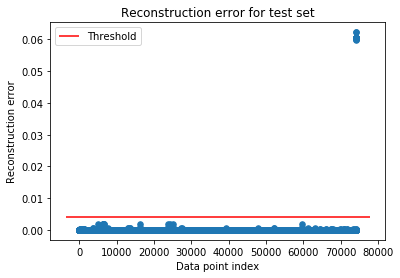

In [153]:
fig, ax = plt.subplots()

ax.plot(np.array(test_batch_mse), marker='o', ms=5.5, linestyle='')
            
ax.hlines(.004, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for test set")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

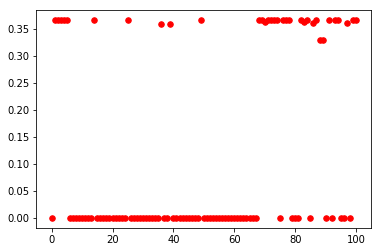

In [198]:
fig, ax = plt.subplots()

ax.plot(test_batch_mse[test_y == 1], marker='o', ms=5.5, linestyle='', color='r')
#ax.plot(test_batch_mse[test_y == 0], marker='o', ms=5.5, linestyle='', color='b')
#ax.hlines(.0004, ax.get_xlim()[0], ax.get_xlim()[1], colors="b", zorder=100, label='Threshold')
plt.show()

In [108]:
# ## This dataset comes from Kaggle - https://www.kaggle.com/dalpozz/creditcardfraud
# ## This tutorial demonstrates how to use unsupervised training for fraud detection. The main model implemented here is auto-encoder, which achives 0.95 of AUC on test set. 
# ### Author: Weimin Wang
# ### Date: June 18, 2017


# Taken from https://github.com/aaxwaz/Fraud-detection-using-deep-learning/blob/master/auto-encoder/autoencoder_demo.ipynb

import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 







    


# ### Test model - on later 25% test data

# In[44]:


save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    #print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))
    #print("Test auc score: " + str(auc(test_y, test_batch_mse)))
    


##### ## Visualize the prediction
####
##### ### 1. Display fraud score (mse) distribution for non-fraud cases
####
##### In[22]:
####
####
####plt.hist(test_batch_mse[test_y == 0.0], bins = 100)
####plt.title("fraud score (mse) distribution of non-fraud cases.")
####plt.xlabel("fraud score (mse)")
####plt.show()
####
####
##### ### Zoom into (0, 20) range
####
##### In[24]:
####
####
####plt.hist(test_batch_mse[(test_y == 0.0) & (test_batch_mse < 20)], bins = 100)
####plt.title("fraud score (mse) distribution for non-fraud cases.")
####plt.xlabel("fraud score (mse)")
####plt.show()
####
####
##### ### 2. Display fraud score (mse) distribution for fraud cases
####
##### In[25]:
####
####
####plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
####plt.title("fraud score (mse) distribution for fraud cases.")
####plt.xlabel("fraud score (mse)")
####plt.show()
####
####
##### In[28]:
####
####
####THRE_TEST = 7
####print("Let's, for example, use 7 as our detection threshold: \nNumber of detected cases above treshold: {}, \nNumber of pos cases only above threshold: {}, \nThe percentage of accuracy above treshold (Precision): {:0.2f}%. \nCompared to the average percentage of fraud in test set: 0.132%".format( np.sum(test_batch_mse > THRE_TEST), np.sum(test_y[test_batch_mse > THRE_TEST]), np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST) * 100))
####      
####
####
##### ### Observation: Our precision increased by a factor of 60 from 0.132% to 7.86%; However, the detection precision is still low (below 8%), but this is mainly due to the overall percentage of fraud cases is really too low. 
####
##### ## 2. Build a binary classifier that predicts fraud, using the auto-encoder embedding layers as model inputs. 
####
##### ### 1) Get auto-encoder embedding (the `encoder_op` tensor) for both train and test data
####
##### In[45]:
####
####
####save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
####saver = tf.train.Saver()
####
##### Initializing the variables
####init = tf.global_variables_initializer()
####
####with tf.Session() as sess:
####    now = datetime.now()
####    saver.restore(sess, save_model)
####    
####    test_encoding = sess.run(encoder_op, feed_dict={X: test_x})
####    train_encoding = sess.run(encoder_op, feed_dict={X: train_x})
####    
####    print("Dim for test_encoding and train_encoding are: \n", test_encoding.shape, '\n', train_encoding.shape)
####
####
##### ### 2) Build the graph for FC layers (best hidden size based on validation is found to be 4)
####
##### In[46]:
####
####
#####n_input = test_encoding.shape[1]
####n_input = test_encoding.shape[1]
####
####hidden_size = 4
####output_size = 2
####
####X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
####y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')
####
####weights = {
####    'W1': tf.Variable(tf.truncated_normal([n_input, hidden_size])),
####    'W2': tf.Variable(tf.truncated_normal([hidden_size, output_size])),
####}
####biases = {
####    'b1': tf.Variable(tf.zeros([hidden_size])),
####    'b2': tf.Variable(tf.zeros([output_size])),
####}
####
####hidden_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
####pred_logits = tf.add(tf.matmul(hidden_layer, weights['W2']), biases['b2'])
####pred_probs = tf.nn.softmax(pred_logits)
####
####cross_entropy = tf.reduce_mean(
####    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))
####
####optimizer = tf.train.AdamOptimizer(2e-4).minimize(cross_entropy)
####
####
##### ### 3) Prepare the data set. 
##### ### Now we need to re-split the train into train/val, due to supervised training.
##### ### We will therefore use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)). 
##### ### Finally we start to train our binary classifier
####
##### In[47]:
####
####
####n_epochs = 80
####batch_size = 256
####
##### PREPARE DATA
####VAL_PERC = 0.2
####all_y_bin = np.zeros((df.shape[0], 2))
####all_y_bin[range(df.shape[0]), df['Class'].values] = 1
####
####train_enc_x = train_encoding[:int(train_encoding.shape[0] * (1-VAL_PERC))]
####train_enc_y = all_y_bin[:int(train_encoding.shape[0] * (1-VAL_PERC))]
####
####val_enc_x = train_encoding[int(train_encoding.shape[0] * (1-VAL_PERC)):]
####val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_encoding.shape[0]]
####
####test_enc_y = all_y_bin[train_encoding.shape[0]:]
####print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0],                                                                         test_encoding.shape[0]))
####
##### TRAIN STARTS
####save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
####saver = tf.train.Saver()
####
##### Initializing the variables
####init = tf.global_variables_initializer()
####
####with tf.Session() as sess:
####    now = datetime.now()
####    sess.run(init)
####    total_batch = int(train_enc_x.shape[0]/batch_size)
####    # Training cycle
####    for epoch in range(n_epochs):
####        # Loop over all batches
####        for i in range(total_batch):
####            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
####            batch_xs = train_enc_x[batch_idx]
####            batch_ys = train_enc_y[batch_idx]
####
####            # Run optimization op (backprop) and cost op (to get loss value)
####            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
####            
####        # Display logs per epoch step
####        if epoch % display_step == 0:
####            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
####            print("Epoch:", '%04d' % (epoch+1),
####                  "cost=", "{:.9f}".format(c), 
####                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
####                  "Time elapsed=", "{}".format(datetime.now() - now))
####
####    print("Optimization Finished!")
####    
####    save_path = saver.save(sess, save_model)
####    print("Model saved in file: %s" % save_path)
####    
####
####
##### ### 4) Test the model on the same test data as before - improved on AUC slightly - 0.9669
####
##### In[48]:
####
####
####save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
####saver = tf.train.Saver()
##### Initializing the variables
####init = tf.global_variables_initializer()
####
####with tf.Session() as sess:
####    now = datetime.now()
####    
####    saver.restore(sess, save_model)
####    
####    test_probs = sess.run(pred_probs, feed_dict={X: test_encoding})
####    
####    print("\nTest auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))
####
####
##### ## 3. (Optional) However, let's test a simple supervisied neural network (two layers FC) from scratch - without using auto-encoder
####
##### ### 1) Build graph - 28 (input) -> 8 -> 4 -> 2
####
##### In[44]:
####
####
####n_epochs = 200
####batch_size = 256
####
#####n_input = test_encoding.shape[1]
####n_input = train_x.shape[1]
####
####hidden1_size = 8
####hidden2_size = 4
####output_size = 2
####
####X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
####y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')
####
####weights = {
####    'W1': tf.Variable(tf.truncated_normal([n_input, hidden1_size])),
####    'W2': tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size])),
####    'W3': tf.Variable(tf.truncated_normal([hidden2_size, output_size])),
####}
####biases = {
####    'b1': tf.Variable(tf.zeros([hidden1_size])),
####    'b2': tf.Variable(tf.zeros([hidden2_size])),
####    'b3': tf.Variable(tf.zeros([output_size])),
####}
####
####hidden1_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
####hidden2_layer =  tf.nn.relu(tf.add(tf.matmul(hidden1_layer, weights['W2']), biases['b2']))
####pred_logits = tf.add(tf.matmul(hidden2_layer, weights['W3']), biases['b3'])
####pred_probs = tf.nn.softmax(pred_logits)
####
####cross_entropy = tf.reduce_mean(
####    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))
####
####optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
####
####
##### ### 2) Prepare the data set. Now we need to re-split the train into train/val. 
##### ### Again, we will use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)).
##### 
####
##### In[45]:
####
####
##### PREPARE DATA
####VAL_PERC = 0.2
####all_y_bin = np.zeros((df.shape[0], 2))
####all_y_bin[range(df.shape[0]), df['Class'].values] = 1
####
####train_enc_x = train_x[:int(train_x.shape[0] * (1-VAL_PERC))]
####train_enc_y = all_y_bin[:int(train_x.shape[0] * (1-VAL_PERC))]
####
####val_enc_x = train_x[int(train_encoding.shape[0] *  (1-VAL_PERC)):]
####val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_x.shape[0]]
####
####test_enc_y = all_y_bin[train_x.shape[0]:]
####
####print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0],                                                                         test_encoding.shape[0]))
##### TRAIN STARTS
####save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
####saver = tf.train.Saver()
####
##### Initializing the variables
####init = tf.global_variables_initializer()
####
####with tf.Session() as sess:
####    now = datetime.now()
####    sess.run(init)
####    total_batch = int(train_enc_x.shape[0]/batch_size)
####    # Training cycle
####    for epoch in range(n_epochs):
####        # Loop over all batches
####        for i in range(total_batch):
####            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
####            batch_xs = train_enc_x[batch_idx]
####            batch_ys = train_enc_y[batch_idx]
####            # Run optimization op (backprop) and cost op (to get loss value)
####            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
####            
####        # Display logs per epoch step
####        if epoch % display_step == 0:
####            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
####            print("Epoch:", '%04d' % (epoch+1),
####                  "cost=", "{:.9f}".format(c), 
####                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
####                  "Time elapsed=", "{}".format(datetime.now() - now))
####
####    print("Optimization Finished!")
####    
####    save_path = saver.save(sess, save_model)
####    print("Model saved in file: %s" % save_path)
####    
####
####
##### ### 3) Predict on test data
####
##### In[47]:
####
####
####save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
####saver = tf.train.Saver()
##### Initializing the variables
####init = tf.global_variables_initializer()
####
####with tf.Session() as sess:
####    now = datetime.now()
####    
####    saver.restore(sess, save_model)
####    
####    test_probs = sess.run(pred_probs, feed_dict={X: test_x})
####    
####    print("Test auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))
####
####
##### In[ ]:
####
####
####
####
####
##### In[ ]:
####
####
####
####
####
##### In[ ]:
####
####
####
####
####
##### In[ ]:
####
####
####
####


INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
